<a href="https://colab.research.google.com/github/m7saikat/IE-7374/blob/master/Lab_4_2_3_Policy_Improvement_and_Policy_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time

In [0]:
def update_values(states, policy, values):
    delta = 0
    for state, action in zip(states, policy):
        # Get s_prime according to action
        # Note: p(s_prime | s, pi(s)) = 1
        s_prime = state.copy()
        s_prime[0] -= action
        s_prime[1] += action
        s_prime = np.clip(s_prime, 0, 20)

        # Store old value to check delta
        v = values[state[0], state[1]]

        # Get joint probability of r over range of rental/return rates
        # and calculate the updated value
        n_rentals_2, n_rentals_1, n_returns_2, n_returns_1 = (
            np.meshgrid(range(POISSON_UB), range(POISSON_UB),
                        range(POISSON_UB), range(POISSON_UB)))
        
        rentals_joint_probs = np.outer(POISSON3, POISSON4) 
        n_rentals_1 = np.minimum(n_rentals_1, s_prime[0]) 
        n_rentals_2 = np.minimum(n_rentals_2, s_prime[1])  
        rewards = (10 * np.add(n_rentals_1, n_rentals_2).flatten()
                   - 2 * abs(action))  

        returns_joint_probs = np.outer(POISSON3, POISSON2)  
        n_final_1 = np.minimum((
                n_returns_1 - n_rentals_1 + s_prime[0]), 20).flatten()  
        n_final_2 = np.minimum((
                n_returns_2 - n_rentals_2 + s_prime[1]), 20).flatten()  

        v_prime = values[n_final_1, n_final_2]  
        joint_probs = np.outer(rentals_joint_probs,
                               returns_joint_probs).flatten()  
        values[state[0], state[1]] = (joint_probs
                                      @ (rewards + GAMMA * v_prime))

        # Compare delta
        delta = max(delta, abs(v - values[state[0], state[1]]))
    return values, delta


In [0]:
def update_policy(states, policy, values):
    stable = True
    for i in range(states.shape[0]):
        state = states[i]
        old_action = policy[i]

        # Build action space
        actions_lb = np.amax([state[0] - 20, -state[1], -5])
        actions_ub = np.amin([state[0], 20 - state[1], 5])
        actions = np.arange(actions_lb, actions_ub + 1)
        action_values = []

        for action in actions:
            # Get s_prime according to action
            # Note: p(s_prime | s, a) = 1
            s_prime = state.copy()
            s_prime[0] -= action
            s_prime[1] += action
            s_prime = np.clip(s_prime, 0, 20)

            n_rentals_2, n_rentals_1, n_returns_2, n_returns_1 = (
                np.meshgrid(range(POISSON_UB), range(POISSON_UB),
                            range(POISSON_UB), range(POISSON_UB)))

            rentals_joint_probs = np.outer(POISSON3, POISSON4)  # shape = (12, 12)
            n_rentals_1 = np.minimum(n_rentals_1, s_prime[0])  # shape = (12, 12, 12, 12)
            n_rentals_2 = np.minimum(n_rentals_2, s_prime[1])  # shape = (12, 12, 12, 12)

            rewards = (10 * np.add(n_rentals_1, n_rentals_2).flatten()
                       - 2 * abs(action))  # shape = 12 ** 4 = 20736

            returns_joint_probs = np.outer(POISSON3, POISSON2)  # shape = (12, 12)
            n_final_1 = np.minimum((
                    n_returns_1 - n_rentals_1 + s_prime[0]), 20).flatten()  # shape = 12 ** 4 = 20736
            n_final_2 = np.minimum((
                    n_returns_2 - n_rentals_2 + s_prime[1]), 20).flatten()  # shape = 12 ** 4 = 20736
            v_prime = values[n_final_1, n_final_2]  # shape = 20736

            joint_probs = np.outer(rentals_joint_probs,
                                   returns_joint_probs).flatten()  # shape = 12 ** 4 = 20736
            action_values.append((joint_probs
                                  @ (rewards + GAMMA * v_prime)))

        policy[i] = actions[np.argmax(action_values)]

        if stable and policy[i] != old_action:
            stable = False

    return policy, stable

Defining Constants

In [0]:
 # Maximum number of cars at each location
MAX = 20

# Policy evaluation convergence limit
EPSILON = 1e-5

# Discount factor
GAMMA = 0.9  

# Poisson pmf is negligible above this upper bound
POISSON_UB = 12 
# lambda = 2
POISSON2 = poisson.pmf(range(POISSON_UB), 2)  
# lambda = 3
POISSON3 = poisson.pmf(range(POISSON_UB), 3) 
# lambda = 4 
POISSON4 = poisson.pmf(range(POISSON_UB), 4) 
# State space
STATES = (np.array([[x, y] for x in range(MAX + 1)
                    for y in range(MAX + 1)]))

In [0]:
def main():
  
    # Initialize values arbitrarily in grid shape (21, 21)
    values = np.zeros((MAX + 1, MAX + 1))

    # Initialize policy to move zero cars
    policy = np.zeros(STATES.shape[0])

    # Plot initial policy
    plt.figure()
    plt.title(f'Policy at step {0}')
    plt.xlabel('Cars at first location')
    plt.ylabel('Cars at second location')
    plt.contourf(policy.reshape(21, 21))
    plt.colorbar()

    # Policy Iteration
    stable = False
    steps = 0
    while not stable:
        # Policy Evaluation
        while True:
            values, delta = update_values(STATES, policy, values)
            print('Delta : {}.'.format(delta))
            if delta < EPSILON:
              break

        # Policy Improvement
        policy, stable = update_policy(STATES, policy, values)

        steps += 1

        # Generate plots
        plt.figure()
        plt.title(f'Policy at step {steps}')
        plt.xlabel('Cars at second location')
        plt.ylabel('Cars at first location')
        plt.contourf(policy.reshape(21, 21))
        plt.colorbar()

    # Plot final value function
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title('Final value function')
    ax.set_xlabel('Cars at second location')
    ax.set_ylabel('Cars at first location')
    ax.set_zlabel('Expected profit')
    X, Y = np.meshgrid(range(21), range(21))
    ax.plot_surface(X, Y, values, rstride=1, cstride=1)

    plt.show()

Delta : 205.674395751218.
Delta : 133.60215805459518.
Delta : 89.6117970819057.
Delta : 65.55780363046316.
Delta : 53.41015773242361.
Delta : 42.75095551552346.
Delta : 34.042104283168044.
Delta : 27.118021207256334.
Delta : 21.796896461591587.
Delta : 17.904414743736197.
Delta : 14.68091924150724.
Delta : 12.02304869255471.
Delta : 9.837864339348016.
Delta : 8.044844194043947.
Delta : 6.575646013496566.
Delta : 5.3729804549475375.
Delta : 4.389203070288829.
Delta : 3.5848999537149666.
Delta : 2.9275848560859004.
Delta : 2.3905505400874745.
Delta : 1.9518814108066636.
Delta : 1.5936180629631735.
Delta : 1.3010576703701986.
Delta : 1.0621722677008165.
Delta : 0.8671274559307562.
Delta : 0.7078856063191097.
Delta : 0.5778795680987514.
Delta : 0.4717448568970326.
Delta : 0.3851001469922153.
Delta : 0.3143675397334391.
Delta : 0.25662551277065404.
Delta : 0.20948867620063538.
Delta : 0.1710094906377435.
Delta : 0.13959796157524806.
Delta : 0.1139560377222324.
Delta : 0.09302403062315534.
D

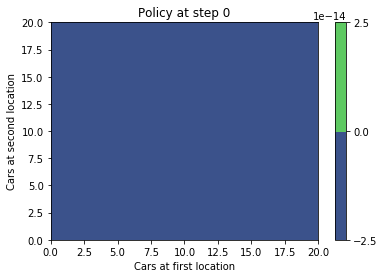

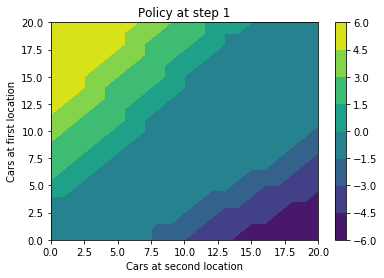

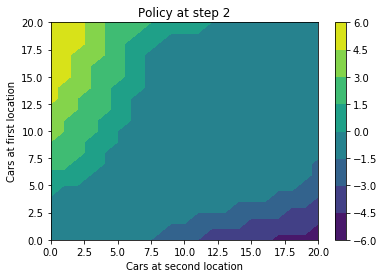

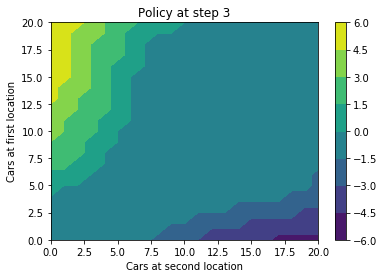

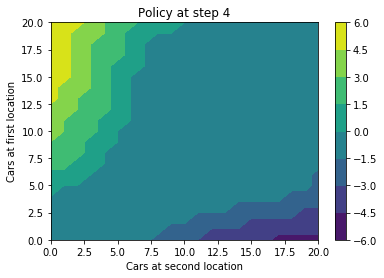

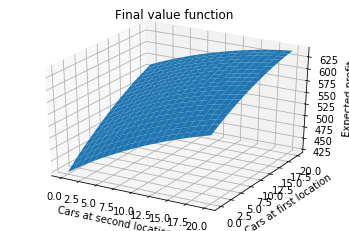

In [0]:
if __name__ == '__main__':
    main()